# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [1]:
!pip install nltk

In [2]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

import re
from string import punctuation

In [3]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Question 1: Input and Basic preprocessing (10 marks)

In [4]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]

def parse_data_line(data_line):
    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    label = convert_label(data_line[1])
    statement = data_line[2]
    return (label, statement)

In [5]:
# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS
    
    # make all texts in lower case
    text = text.lower()
        
    # split into list
    token_draft = text.split()
    token = []
        
    for word in token_draft:
        # locate punctuations
        reg_punctuations = r'[^\w]+'
        if(re.search(reg_punctuations,word)):
            # remove irrelevant punctuations 
            word = word.strip(punctuation)
            
        # remove empty strings in list
        if(len(word) != 0):
            token.append(word)
    
    #return list of words
    return token

# Question 2: Basic Feature Extraction (20 marks)

In [6]:
global_feature_dict = {} # word: index

def to_feature_vector(token):
    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS
    feature_vector = {} # index: weight
    for word in token:
        try:
            # word found in dic, get index 
            i = global_feature_dict[word]
        except KeyError: # error thrown when retrieving [word] = new word not found in dictionary
            i = len(global_feature_dict) + 1
            global_feature_dict[word] = i
        # assigning weight to the features
        try:
            # repeated word, increase weight value weight += 1 (counting frequency of words)
            feature_vector[i] += 1
        except KeyError: # error thrown when retrieving [i] = new index not found in featureVector
            feature_vector[i] = 1
    return feature_vector

In [7]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [8]:
#solution
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_data_cv = {}
train_data_cv = {}
def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    
    counter = 0 # used to get
    precision = 0 # tp/(tp+fp)
    recall = 0 # tp/(tp+fn)
    f1_score = 0 # 2PR/(P+R)
    accuracy = 0
    fold_num = 1
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
        last_index_test = i + fold_size - counter
        size_of_test_set = int(fold_size/folds)
        start_index_test = last_index_test - size_of_test_set
        counter += size_of_test_set
        test_indexes = []
        train_indexes = []
        test_data = []
        train_data = []
        ## test data
        # get the test indexes for the fold
        for j in range(start_index_test, last_index_test+1):
            if(j < len(dataset)):
                test_indexes.append(j)
        
        # get the test data for the fold
        for j in test_indexes:
            data = dataset[j]
            test_data.append(data)
        
        test_data_cv[f'Fold {fold_num}'] = test_data
        
        ## train data
        # get the train indexes for the fold
        fold_range = i+fold_size+1 #plus one to include last value
        for k in range(i,fold_range):
            if k not in test_indexes:
                if(k < len(dataset)): # make sure k index value is still within index of dataset
                    train_indexes.append(k)
        
        # get the train data for the fold
        for k in train_indexes:
            data = dataset[k]
            train_data.append(data)
        
        train_data_cv[f'Fold {fold_num}'] = train_data
        
        training = train_classifier(train_data)  # train the data classifier in each fold
        test_y_pred = predict_labels([x[0] for x in test_data], training) # evaluate the trained data on test data in each fold to get test prediction
        
        test_y_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
        final_scores = precision_recall_fscore_support(test_y_true, test_y_pred, average='weighted') 
        
        print(classification_report(test_y_true,test_y_pred))
        print('--'*20)
        
        precision += final_scores[0]
        recall += final_scores[1]
        f1_score += final_scores[2]
        accuracy += accuracy_score(test_y_true,test_y_pred)
        
        fold_num +=1
    
    precision = precision / folds
    recall = recall / folds
    f1_score = f1_score / folds
    accuracy = accuracy / folds
    
    cv_results = {'precision': precision,'recall': recall, 'f1_score': f1_score, 'accuracy':accuracy}
        
    return cv_results

In [9]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [10]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13674


In [11]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
              precision    recall  f1-score   support

        FAKE       0.45      0.41      0.43        34
        REAL       0.62      0.65      0.63        49

    accuracy                           0.55        83
   macro avg       0.53      0.53      0.53        83
weighted avg       0.55      0.55      0.55        83

----------------------------------------
Fold start on items 820 - 1640
Training Classifier...
              precision    recall  f1-score   support

        FAKE       0.39      0.38      0.39        34
        REAL       0.58      0.59      0.59        49

    accuracy                           0.51        83
   macro avg       0.49      0.49      0.49        83
weighted avg       0.50      0.51      0.50        83

----------------------------------------
Fold start on items 1640 - 2460
Training Classifier...
              precision    recall  f1-score   support

        FAKE       0.65      0.62      0.63      

{'precision': 0.5562068297615173,
 'recall': 0.5518072289156626,
 'f1_score': 0.5520140623191052,
 'accuracy': 0.5518072289156626}

# 4. Error Analysis (10 marks)

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    #cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Training Classifier...


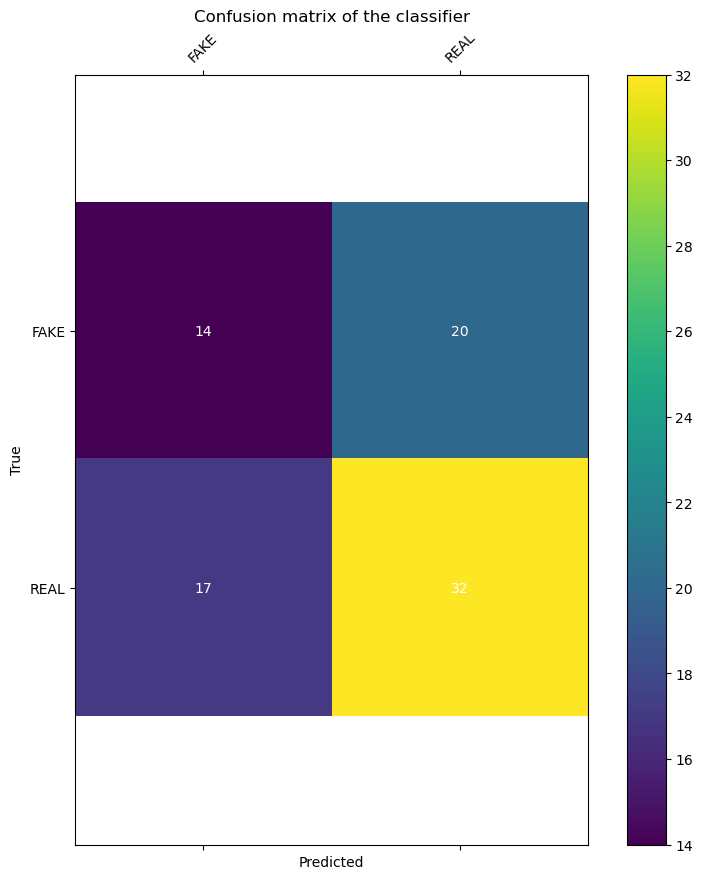

In [13]:
first_fold_train = train_data_cv['Fold 1']
first_fold_test = test_data_cv['Fold 1']

classifier = train_classifier(first_fold_train)  # train the classifier
test_y_true = [t[1] for t in first_fold_test]   # get the ground-truth labels from the data
test_y_pred = predict_labels([x[0] for x in first_fold_test], classifier) 

labels = ['FAKE','REAL']
        
confusion_matrix_heatmap(test_y_true, test_y_pred, labels)

In [14]:
n = len(first_fold_test)

In [15]:
print('\033[4mFalse negative and False positive\033[0m')
for i in range(n):
    dic_fold = first_fold_test[i][0]
    
    actual = first_fold_test[i][1]
    predicted = test_y_pred[i]
    false_pos = (actual == 'FAKE' and predicted == 'REAL')
    false_neg = (actual == 'REAL' and predicted == 'FAKE')
    if(false_pos or false_neg):
        print(f'{i}: ', end = ' ')
    for key, val in dic_fold.items():
        for key_g, val_g in global_feature_dict.items():
            if(key == val_g):
                if(false_pos or false_neg):
                    print(key_g, end = ' ')
    if(false_pos):
        print()
        print(f'\033[1mActual\033[0m -> {actual} | \033[1mPredicted\033[0m -> {predicted} \033[1m(False Positive)\033[0m')
        print()
    elif(false_neg):
        print()
        print(f'\033[1mActual\033[0m -> {actual} | \033[1mPredicted\033[0m -> {predicted} \033[1m(False Negative)\033[0m')
        print()

False negative and False positive
0:  says in the last 20 years french have not stood by united states on foreign policy 
Actual -> FAKE | Predicted -> REAL (False Positive)

3:  says attorney general loretta lynch was a member of bill clintons defense team during the 1992 whitewater corruption probe 
Actual -> FAKE | Predicted -> REAL (False Positive)

5:  barack obama passed laws moving people from welfare to work 
Actual -> REAL | Predicted -> FAKE (False Negative)

7:  says president barack obama promised a pathway to citizenship undocumented immigrants and didnt deliver jack squat on any of it 
Actual -> REAL | Predicted -> FAKE (False Negative)

11:  the proposed gogebic mine in northern wisconsin could be extended as long 21 miles 
Actual -> REAL | Predicted -> FAKE (False Negative)

15:  says richard burr was one of only three senators who voted against a ban on insider trading for members congress and he called that vote brave 
Actual -> REAL | Predicted -> FAKE (False Negativ

# Questions 5 (20%) and 6 (20%) (on a new notebook)

In [16]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({2: 2, 42: 1, 265: 1, 699: 1, 614: 1, 25: 1, 847: 1, 136: 1, 7930: 1, 1837: 1, 15: 1, 484: 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.554570
Recall: 0.554905
F Score:0.554729
